# Import Libraries

In [29]:
import tensorflow as tf
import tensorflow_datasets as tdfs

import os, re, time, json

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image, PIL.ImageFont, PIL.ImageDraw

from tensorflow.keras.layers import  Dense, Flatten, Conv2D, AveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model


# Data

In [16]:
'''
Transforms each image in dataset by pasting it on a 75x75 canvas at random locations.
'''

def load_tdfs(image, label):
  tf.random.set_seed(1)
  xmin = tf.random.uniform((), 0, 48, dtype=tf.int32)
  ymin = tf.random.uniform((), 0, 48, dtype=tf.int32)
  image = tf.reshape(image, (28,28,1,))
  image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75,75)
  image = tf.cast(image, float)/255.
  xmin, ymin = tf.cast(xmin, float), tf.cast(ymin, float)

  xmax = (xmin + 28) / 75
  ymax = (ymin + 28) / 75
  xmin = xmin / 75
  ymin = ymin / 75
  return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])

'''
Loads and maps the validation split of the dataset using the map function. 
Note that we try to load the gcs version since TPU can only work with datasets on Google Cloud Storage.
''' 

def get_train_data():
  dataset = tdfs.load('mnist', split= 'train', as_supervised=True, try_gcs=True)
  dataset = dataset.map(load_tdfs, num_parallel_calls=16)
  dataset = dataset.cache() # this small dataset can be entirely cached in RAM
  dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
  dataset = dataset.batch(128, drop_remainder = True)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(-1) # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
  return dataset

def get_val_data():
  dataset = tdfs.load('mnist', split= 'test', as_supervised=True, try_gcs=True)
  dataset = dataset.map(load_tdfs, num_parallel_calls=16)
  dataset = dataset.cache() # this small dataset can be entirely cached in RAM
  dataset = dataset.batch(5000, drop_remainder = True)
  dataset = dataset.repeat()
  return dataset

   
train_data = get_train_data()
test_data = get_val_data()   

In [17]:
train_data

<PrefetchDataset shapes: ((128, 75, 75, 1), ((128, 10), (128, 4))), types: (tf.float32, (tf.float32, tf.float32))>

In [18]:
test_data

<RepeatDataset shapes: ((5000, 75, 75, 1), ((5000, 10), (5000, 4))), types: (tf.float32, (tf.float32, tf.float32))>

# Model

In [33]:
def feature_extractor(inputs):
  x = Conv2D(16, 3, activation='relu', input_shape = (75,75,1))(inputs)
  x = AveragePooling2D((2,2))(x)

  x = Conv2D(32, 3, activation='relu')(x)
  x = AveragePooling2D()(x)

  x = Conv2D(64, 3, activation='relu')(x)
  x = AveragePooling2D()(x)
  return x


def dense_layer(x):
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  return x


def classifier(x):
  x = Dense(10, activation='softmax', name = 'classifier')(x)
  return x


def bounding_box_regression(x):
  bounding_box_regression = Dense(4, name = 'bounding_box_regression')(x)
  return bounding_box_regression 


def final_model():
  inp = Input(shape= (75,75,1,))
  x = feature_extractor(inp)
  x = dense_layer(x)

  classifier_out = classifier(x)
  bounding_box_out = bounding_box_regression(x)

  model = Model(inputs = inp, outputs = [classifier_out, bounding_box_out])
  return model


model = final_model()

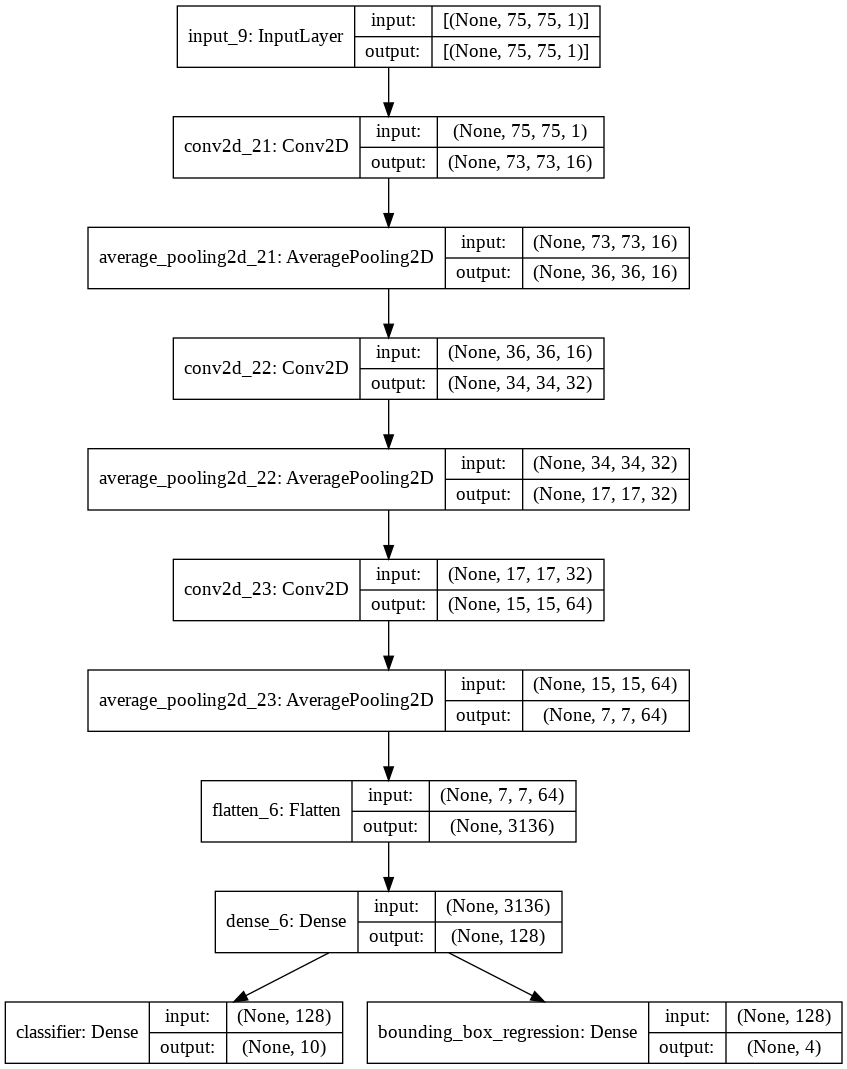

In [34]:
plot_model(model, show_layer_names=True, show_shapes=True)

## Lets compile the model

In [37]:
model.compile(optimizer='adam', 
              loss = {'bounding_box_regression': 'mse',
                      'classifier': 'categorical_crossentropy'},
              
              metrics = {'classifier' : 'accuracy',
                         'bounding_box_regression' : 'mse'
                        })  #because of one-hot encoding

## Train and Validate model

In [39]:
BATCH_SIZE = 128
EPOCHS = 5 # 45
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
validation_steps = 1

history = model.fit(train_data,
                    steps_per_epoch=steps_per_epoch, validation_data=test_data,
                    validation_steps=validation_steps, epochs=EPOCHS)

Epoch 1/10
468/468 [==============================] - 229s 486ms/step - loss: 1.7757 - classifier_loss: 1.7471 - bounding_box_regression_loss: 0.0286 - classifier_accuracy: 0.3528 - bounding_box_regression_mse: 0.0286 - val_loss: 0.3901 - val_classifier_loss: 0.3742 - val_bounding_box_regression_loss: 0.0158 - val_classifier_accuracy: 0.8810 - val_bounding_box_regression_mse: 0.0158
Epoch 2/10
468/468 [==============================] - 223s 475ms/step - loss: 0.3615 - classifier_loss: 0.3484 - bounding_box_regression_loss: 0.0131 - classifier_accuracy: 0.8968 - bounding_box_regression_mse: 0.0131 - val_loss: 0.2471 - val_classifier_loss: 0.2393 - val_bounding_box_regression_loss: 0.0078 - val_classifier_accuracy: 0.9268 - val_bounding_box_regression_mse: 0.0078
Epoch 3/10
468/468 [==============================] - 222s 475ms/step - loss: 0.2340 - classifier_loss: 0.2263 - bounding_box_regression_loss: 0.0077 - classifier_accuracy: 0.9319 - bounding_box_regression_mse: 0.0077 - val_loss

# Intersection over union
Calculate the I-O-U metric to evaluate the model's performance.


In [40]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)


    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(xmin_pred, xmin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred + 1) * (ymax_pred - ymin_pred + 1)
    true_box_area = (xmax_true - xmin_true + 1) * (ymax_true - ymin_true + 1)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap) + 1,0)  * np.maximum((ymax_overlap - ymin_overlap) + 1, 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    iou = overlap_area / union_area

    return iou